# Single molecule - Manual Pipeline

____
This code is intended to take a video (.tiff) from fluorescence microscopy, segment the cell,detect single-RNA spots, track the single-RNA spots in time, and quantify spot intensity.
____
The code is divided in the following sections:

* Alignment images taken from the two cameras.
* Load microscope video.
* Mask selection. Manual selection of a Region Of Interest (ROI).
* Particle tracking using trackpy. 
____

## Loading libraries and images
___

In [1]:
from skimage.io import imread
import numpy as np 
import pathlib
import sys
import matplotlib.pyplot as plt 
import cv2
import ipywidgets as widgets                       # Library to plot widgets
from ipywidgets import interact, interactive, HBox, Layout, VBox #  importing modules and functions.
from cellpose import models
from IPython.display import HTML
from scipy.optimize import curve_fit

from matplotlib.animation import FuncAnimation, PillowWriter

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
#video_dir = current_dir.parents[1].joinpath('DataBases','test_short_videos','ran_short','MAX_Cell01.tif')

In [3]:
# Importing rSNAPed
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp

In [4]:
# Loading images
video_dir = current_dir.parents[1].joinpath('DataBases/KDM5B_Translation_SampleMovies/standard_format/BLC_BG_MAX_Cell_02_4mW561_10mW637.tif'); number_color_channels = 3
#video_dir = current_dir.parents[1].joinpath('DataBases/CAP_IRES/BG_MAX_Cell04.tif'); number_color_channels = 3
#video_dir = current_dir.parents[1].joinpath('DataBases/videos_for_sim_cell/cell_shape_0.tif'); number_color_channels = 2
video = imread(video_dir)
print(video.shape)

(300, 512, 512, 3)


In [5]:
# @title Visualizing the simulated video. (Video speed 4X)
max_frames = video.shape[0]
reduced_video = video[0:max_frames,:,:,:]
fig,axes = plt.subplots(1,3,dpi=120,figsize=(10,3))
i=0
# Define inital frames
Red = reduced_video[i,:,:,0]
im1 = axes[0].imshow(Red,cmap='Greys_r')
Green = reduced_video[i,:,:,1]
im2 = axes[1].imshow(Green,cmap='Greys_r')
Blue = reduced_video[i,:,:,2]
im3 =  axes[2].imshow(Blue,cmap='Greys_r')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title('Channel 0')
axes[1].set_title('Channel 1')
axes[2].set_title('Channel 2')

def movieFrame(i):
    Red = reduced_video[i,:,:,0]
    Green = reduced_video[i,:,:,1]
    Blue = reduced_video[i,:,:,2]
    images = [Red,Green,Blue]
    image_handles = [im1,im2,im3]
    for k,image_n in enumerate(images):
        image_handles[k].set_array(images[k])
    return image_handles

plt.close()
#anim = FuncAnimation(fig, movieFrame, frames=max_frames, interval=250, blit=True)
#HTML(anim.to_html5_video())
#anim.save("simulated_cell_1.gif", dpi=300, writer=PillowWriter(fps=5))




### Photobleaching correction steps:

1. Original video.
2. calculate mask
3. average intensity over time.
4. fit exponential.
   1. correction. to the image (complete image). (Priority).

### rsnaped Photobleaching simulation

1. match to non-corrected videos.
2. how to simulate it. 
   1. Generate images and apply the exponential photobleaching to each frame and color channel (3 rates). (Priority).
   2. Generate images (blank images unchanged), but the spots are photobleached and then added to the image (3 rates). (Do if step 2.1 doesn't work)
   3. Combination of the above with 6 parameters. Estimate parameters from original videos? (Do if step 2.2 doesn't work)


In [6]:
print(video.shape)

(300, 512, 512, 3)


# Mean intensity in the complete image

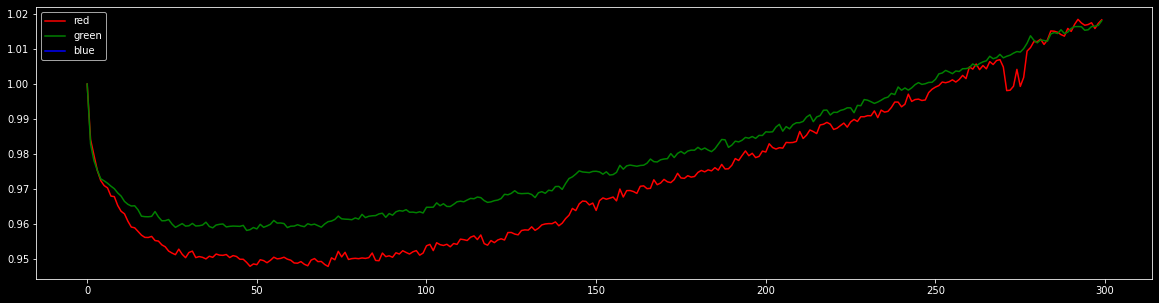

In [7]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))
matrix_intensity_in_time = np.zeros((3,video.shape[0]))
for i in range(video.shape[0]):
    for j in range(number_color_channels):
        matrix_intensity_in_time[j,i] = np.mean(video[i,:,:,j])
ax.set_prop_cycle(color=['red', 'green', 'blue'])
ax.plot(matrix_intensity_in_time.T/matrix_intensity_in_time[:,0])
plt.legend(['red','green','blue'])

# Mean intensity in the cell

In [11]:
# keeping only the largest mask.
model = models.Cellpose(gpu=True, model_type='cyto') # model_type='cyto' or model_type='nuclei'
masks= model.eval(video[0,:,:,0], diameter=200, min_size=1000, channels=[0,0])[0]
num_cells = np.max(masks)

if num_cells>1:
    masks_area = [np.count_nonzero(masks==j) for j in range(1, num_cells+1)]
    largest_mask_index = np.argmax(masks_area) +1   
    largest_mask =  np.where(masks == largest_mask_index, 1, 0) 
else:
    largest_mask = masks

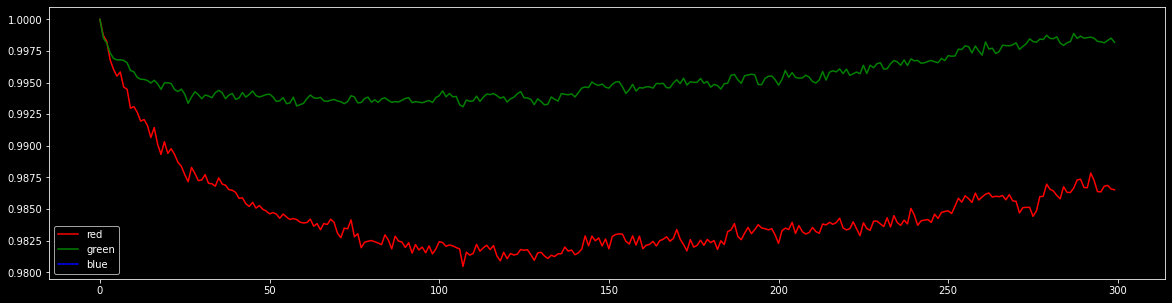

In [13]:
# Compute and plot the mean intensities over time of for each color and each cell.
fig, ax = plt.subplots(1,num_cells, figsize=(20, 5))
#for k in range(num_cells): 
matrix_intensity_in_time = np.zeros((3,video.shape[0]))
for i in range(video.shape[0]):
    for j in range(number_color_channels):
        matrix_intensity_in_time[j,i] = np.sum(video[i,:,:,j]*largest_mask)/np.sum(largest_mask)
ax.set_prop_cycle(color=['red', 'green', 'blue'])
ax.plot(matrix_intensity_in_time.T/matrix_intensity_in_time[:,0])
plt.legend(['red','green','blue'])

In [14]:
def correct_photobleaching_video(video, mask=None, normalized=False, guess = None, niter=10000):
    # get the average intensity in the mask for each channel
    average_ints = np.zeros([video.shape[0], video.shape[-1],]   )
    for i in range(video.shape[0]):
        for j in range(video.shape[-1]):
            if not (mask is None):
                average_ints[i,j] = np.mean(video[i,:,:,j][mask == 1])
            else:
                average_ints[i,j] = np.mean(video[i,:,:,j])
    try:  #generate an initial guess
        guess[0]
    except:
        guess = (np.mean(average_ints[0])*.5, .3,)
    
    def expo(x,a,c):        
        '''
        exponential function.
        '''
        #c = np.abs(c)
        return a*np.exp(-c*x)

    corrected_video = np.zeros(video.shape) #preallocate final video
    tvec = range(video.shape[0]) #time vector for fitting
    exponentials = np.zeros(average_ints.shape) #array for exponentials
    
    for i in range(video.shape[-1]): # for each trajectory
        # fit the exponential curve
        opt,cov = curve_fit(expo,tvec,average_ints[:,i],p0=guess,maxfev=niter)
        exponentials[:,i] = expo(tvec,opt[0],opt[1])
        if normalized:
            exponentials[:,i] = expo(tvec,opt[0],opt[1])
        else:
            exponentials[:,i] = expo(tvec,1.0,opt[1])

    #correct each frame for each channel
    for i in range(video.shape[-1]):
        for j in range(video.shape[0]):
            corrected_video[j,:,:,i] = video[j,:,:,i]/exponentials[j,i] 
    return corrected_video, exponentials, opt, cov

In [16]:
corrected_video, exponentials, opt, cov = correct_photobleaching_video(video, mask=largest_mask, normalized=False, guess = None, niter=10000)

In [17]:
corrected_video.shape

(300, 512, 512, 3)

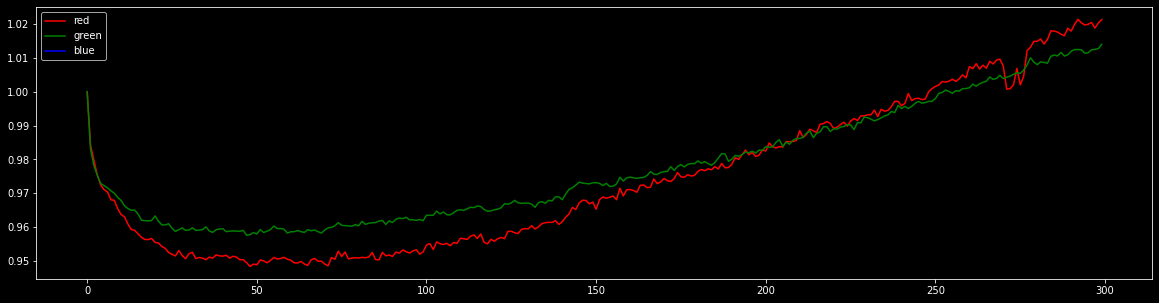

In [19]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))
matrix_intensity_in_time = np.zeros((3,corrected_video.shape[0]))
for i in range(corrected_video.shape[0]):
    for j in range(number_color_channels):
        matrix_intensity_in_time[j,i] = np.mean(corrected_video[i,:,:,j])
ax.set_prop_cycle(color=['red', 'green', 'blue'])
ax.plot(matrix_intensity_in_time.T/matrix_intensity_in_time[:,0])
plt.legend(['red','green','blue'])